In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from semi_exp_clip import load_dataset, CLIP
from semi_exp_viz import *
import datetime

os.chdir(os.path.expanduser("~")+'/cmap')

def pca_color(df_p):
    rgba = df_p[['pca0', 'pca1', 'pca2']]/40+0.5
    rgba.columns = ['r','g', 'b']
    rgba['a'] = 1
    if rgba.max(axis=None) > 1 or rgba.min(axis=None) < 0:
        print('rgba max or min overflowed')
    return pd.concat([df_p, rgba], axis=1)

def import_vector(df, fn):
    with open(fn,"rb") as f:
        features = pickle.load(f)
    features = pd.DataFrame(features)
    df_f = pd.concat([df, features], axis=1)
    return df_f

class PCA:
    def __init__(self, profile=None, n=3):
        try:
            with open(profile, "rb") as f:
                _profile = pickle.load(f)
            [self.mean, self.std, self.top_evec] = _profile
        except: print("No profile data, use .fit to fit data")

    def fit(self, data, fn=None, n=3):
        data_pca = None
        vec = self.preprocess(data)
        vec = vec.to_numpy()
        self.mean = np.mean(vec, axis=0)
        self.std = np.std(vec, axis=0)
        vec_std = (vec - self.mean) / self.std
        self.cov = np.cov(vec_std, rowvar=False)
        self.eival, self.eivec = np.linalg.eig(self.cov)
        self.ind = np.argsort(self.eival)[::-1]
        sorted_eigenvectors = self.eivec[:, self.ind]
        self.top_evec = sorted_eigenvectors[:, :n]
        self.data_pca = np.dot(vec_std, self.top_evec)
        if fn is None:
            if not os.path.exists('./result'): os.makedirs('./result')
            t = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            fn='./result/pca_profile_'+str(t)+'.pkl'
            with open(fn,"wb") as f:
                pickle.dump([self.mean, self.std, self.top_evec], f)
            print('Profile saved at :', fn)
        else: 
            with open(fn,"wb") as f:
                pickle.dump([self.mean, self.std, self.top_evec], f)
        self.data_pca = pd.DataFrame(self.data_pca, columns=['pca0', 'pca1', 'pca2'])
        print('min :', self.data_pca.min(axis=0))
        print('max :', self.data_pca.max(axis=0))
        
        return pd.concat([data, self.data_pca], axis=1)

    def preprocess(self, df_f):
        # get vectors from df_f
        df_out = pd.DataFrame({col: df_f[col] for col in df_f.columns if isinstance(col, int)})
        return df_out

    def standardize(self, data):
        data = self.preprocess(data)
        return (data - self.mean) / self.std
    
    def transform(self, data):
        data_std = self.standardize(data)
        self.n_data_pca = np.dot(data_std, self.top_evec)
        self.n_data_pca = pd.DataFrame(self.n_data_pca, columns=['pca0', 'pca1', 'pca2'])
        print('min :', self.n_data_pca.min(axis=0))
        print('max :', self.n_data_pca.max(axis=0))
        return pd.concat([data, self.n_data_pca], axis=1)


2024-03-06 14:38:19.726 | SUCCESS  | robotathome.core.reader:__open_dataset:141 - Connection is established: rh.db


Current log level name: INFO
No profile data, use .fit to fit data
Profile saved at : ./result/pca_profile_2024-03-06_14-38-23.pkl
min : pca0   -15.864123
pca1   -14.662937
pca2   -17.792345
dtype: float64
max : pca0    13.221459
pca1    15.480344
pca2    11.775522
dtype: float64


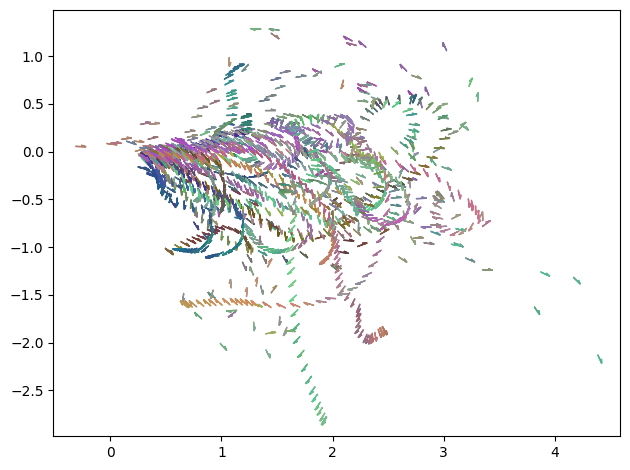

In [2]:
### from scratch
# Load data & CLIP
rh, df, ids = load_dataset('RGBD_1', scale=None)
clip = CLIP(model='ViT-B-32', overwrite=False)
df_s, df_f = clip.encode_rh(rh, df, ids)
# PCA
pca = PCA()
df_p = pca.fit(df_f)
df_p = pca_color(df_p)
plot_viewpoint(df_p, 5, color=True)

min : pca0    -4.369539
pca1     1.463251
pca2   -12.864556
dtype: float64
max : pca0    9.657328
pca1    5.631000
pca2    1.015475
dtype: float64


([<matplotlib.axis.XTick at 0x7fdb1c9f1c90>,
 [Text(0, 0, 'bathroom'),
  Text(1, 0, 'bedroom'),
  Text(2, 0, 'kitchen'),
  Text(3, 0, 'livingroom')])

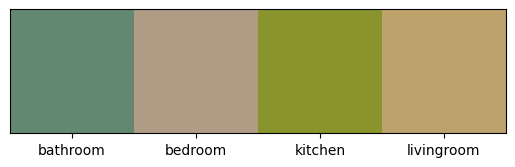

In [4]:
from PIL import Image
import cv2
rooms=['bathroom', 'bedroom', 'kitchen', 'livingroom']
text_features = clip.encode_text(label_list = rooms)
df_t = pd.DataFrame(text_features)
df_t = pca.transform(df_t)
df_t = pca_color(df_t)
df_t = df_t[['r', 'g', 'b']]
df_t = np.array([df_t])
plt.imshow(df_t)
plt.yticks([], [])
plt.xticks([0,1,2,3], rooms)


In [5]:
locator = rh.get_locators()
locator

,home_session_id,home_session_name,home_id,home_name,room_id,room_name,home_subsession_id
0,0,alma-s1,0,alma,0,alma_bathroom1,0
1,0,alma-s1,0,alma,1,alma_bedroom1,0
2,0,alma-s1,0,alma,2,alma_fullhouse1,0
3,0,alma-s1,0,alma,3,alma_kitchen1,0
4,0,alma-s1,0,alma,4,alma_livingroom1,0
...,...,...,...,...,...,...,...
76,6,sarmis-s3,4,sarmis,38,sarmis_fullhouse1,0
77,6,sarmis-s3,4,sarmis,39,sarmis_kitchen1,0
78,6,sarmis-s3,4,sarmis,39,sarmis_kitchen1,1
79,6,sarmis-s3,4,sarmis,40,sarmis_livingroom1,0


2024-03-06 14:38:27.101 | SUCCESS  | robotathome.core.reader:__open_dataset:141 - Connection is established: rh.db


Current log level name: INFO
min : pca0   -15.864123
pca1   -12.280709
pca2   -13.528429
dtype: float64
max : pca0    11.369079
pca1    14.183777
pca2    11.775522
dtype: float64


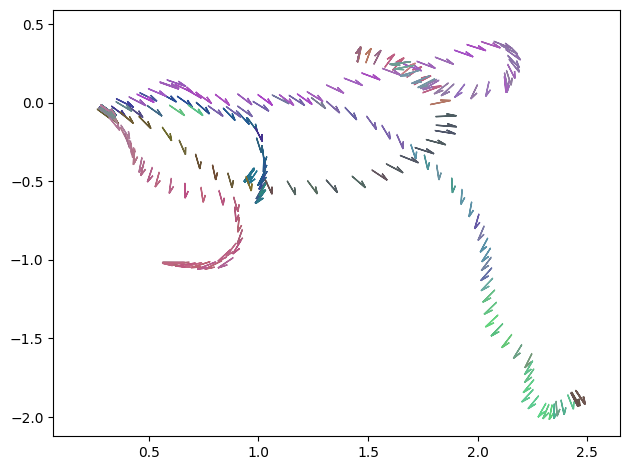

min : pca0   -15.025324
pca1   -14.622897
pca2   -17.792345
dtype: float64
max : pca0    13.221459
pca1    14.007173
pca2     9.416098
dtype: float64


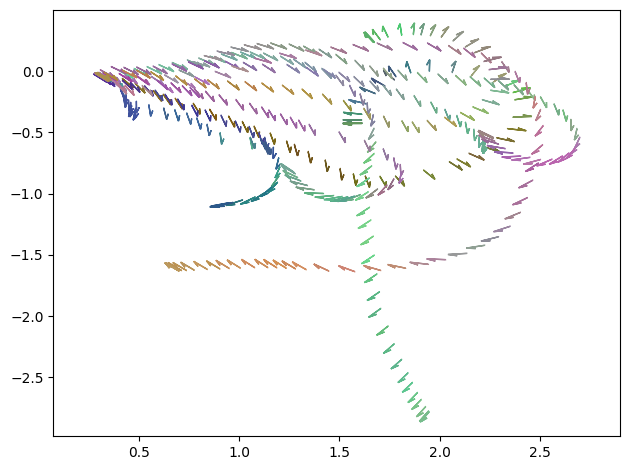

100%|██████████| 2560/2560 [04:05<00:00, 10.44it/s]


average time:  0.096
output dimension: 512
min : pca0   -13.432349
pca1   -14.662937
pca2   -11.793424
dtype: float64
max : pca0    11.626077
pca1    15.480344
pca2    10.477915
dtype: float64


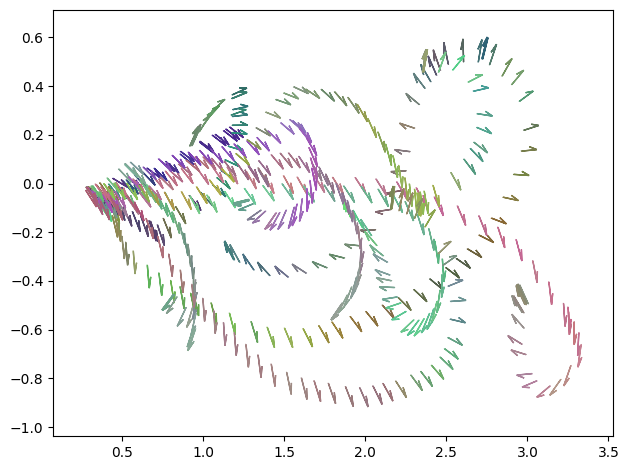

100%|██████████| 934/934 [01:32<00:00, 10.14it/s]


average time:  0.099
output dimension: 512
min : pca0   -13.503872
pca1   -11.480225
pca2   -12.435335
dtype: float64
max : pca0    11.933585
pca1    12.181888
pca2     6.299438
dtype: float64


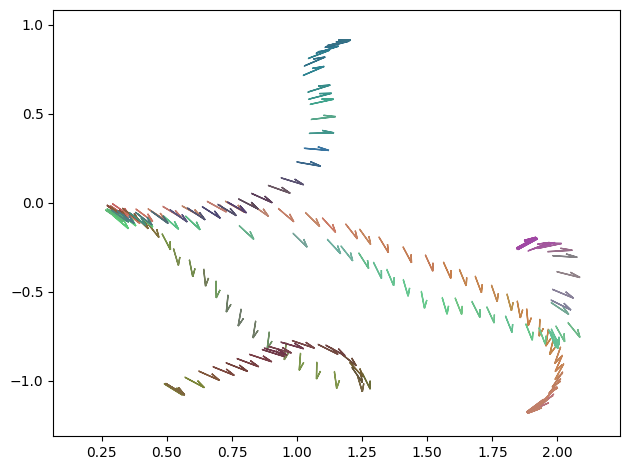

100%|██████████| 528/528 [00:49<00:00, 10.60it/s]


average time:  0.094
output dimension: 512
min : pca0   -14.607826
pca1   -12.416124
pca2   -13.787119
dtype: float64
max : pca0    10.572979
pca1    12.023274
pca2     7.311442
dtype: float64


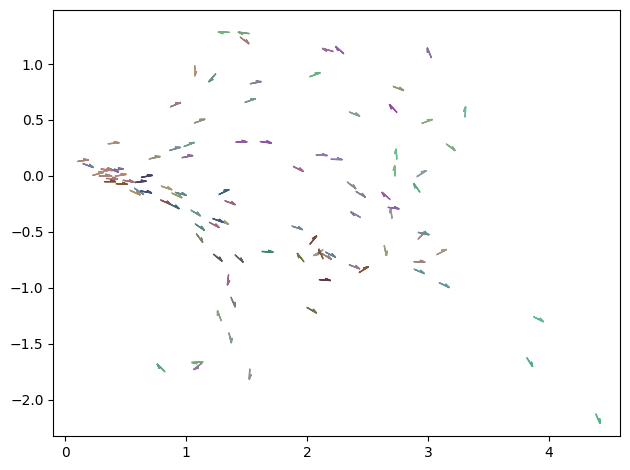

100%|██████████| 426/426 [00:40<00:00, 10.48it/s]


average time:  0.095
output dimension: 512
min : pca0   -13.268310
pca1   -10.746557
pca2   -13.160448
dtype: float64
max : pca0    10.471446
pca1    12.865475
pca2     7.301891
dtype: float64


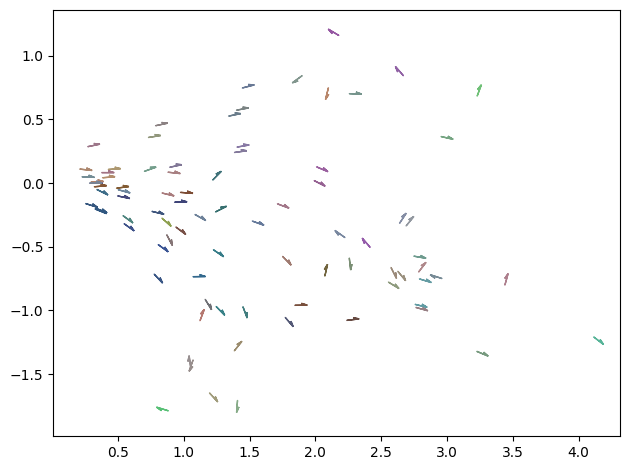

100%|██████████| 412/412 [00:41<00:00,  9.85it/s]


average time:  0.102
output dimension: 512
min : pca0   -14.132545
pca1   -11.847570
pca2   -13.515111
dtype: float64
max : pca0    10.215815
pca1    13.500063
pca2     7.119397
dtype: float64


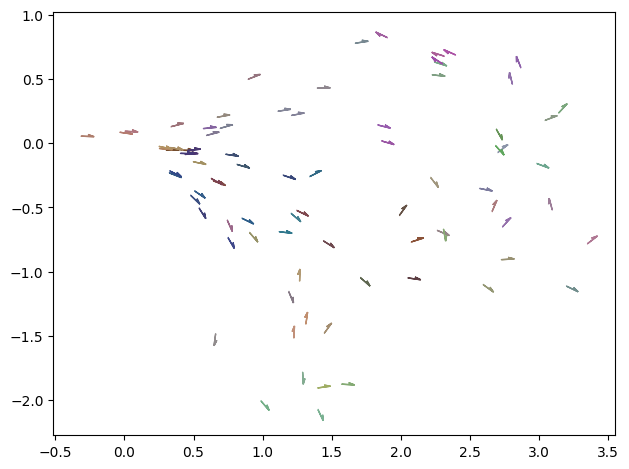

In [5]:
### from existing pca profile
# Load and select data & CLIP
rh, df, ids = load_dataset('RGBD_1', scale=None)
dfs = separate_session(df)
for i, df in enumerate(dfs):
    df = df.sort_values("timestamp")
    df = df.reset_index(drop=True)
    ids = get_ids(df)
    fn = 's'+str(i+1)
    clip = CLIP(model='ViT-B-32', fn=fn)
    df_s, df_f = clip.encode_rh(rh, df, ids)
    # PCA
    pca = PCA(profile='./result/pca_profile.pkl')
    df_p = pca.transform(df_f)
    df_p = pca_color(df_p)
    plot_viewpoint(df_p, 5, color=True)

2024-03-06 15:22:46.140 | SUCCESS  | robotathome.core.reader:__open_dataset:141 - Connection is established: rh.db


Current log level name: INFO
min : pca0   -15.864123
pca1   -12.280709
pca2   -13.528429
dtype: float64
max : pca0    11.369079
pca1    14.183777
pca2    11.775522
dtype: float64


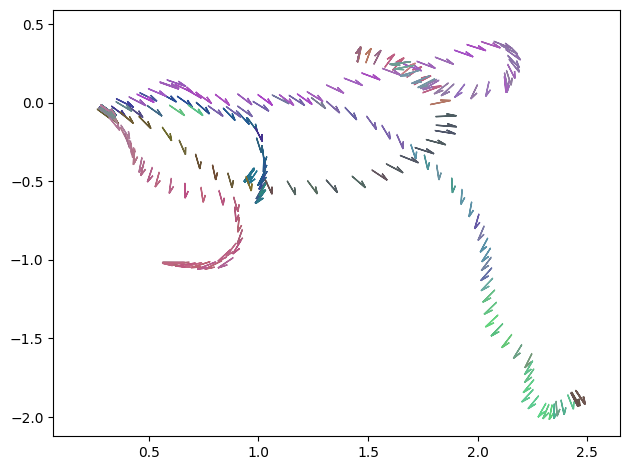

min : pca0    2.969498
pca1   -7.539416
pca2   -4.457862
dtype: float64
max : pca0    11.123066
pca1     1.393511
pca2     4.404403
dtype: float64


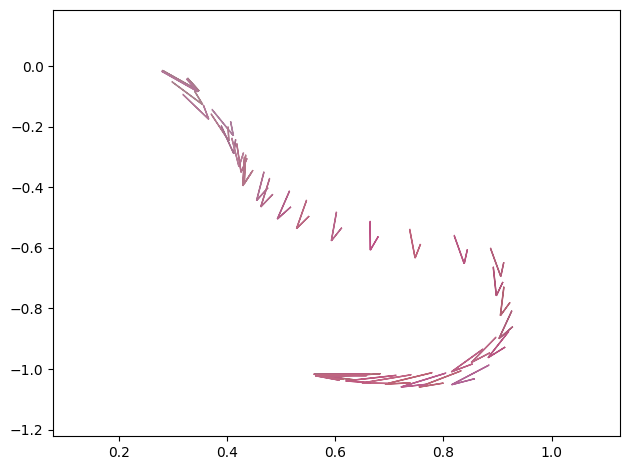

min : pca0    -8.281600
pca1    -8.398026
pca2   -13.528429
dtype: float64
max : pca0    11.369079
pca1     1.126962
pca2     1.796861
dtype: float64


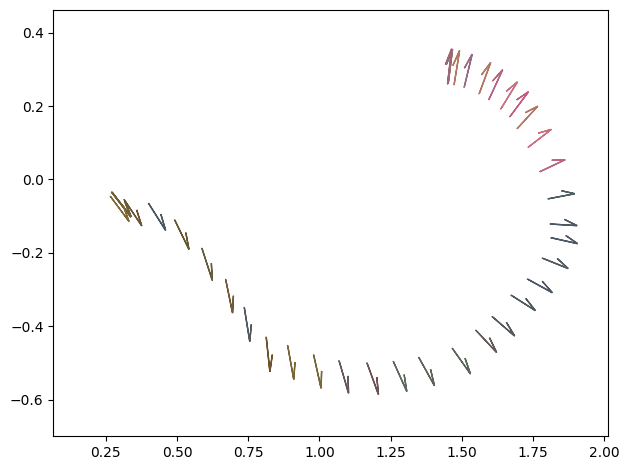

min : pca0   -15.704278
pca1   -12.280709
pca2    -1.414368
dtype: float64
max : pca0   -7.694596
pca1    2.390700
pca2    4.593532
dtype: float64


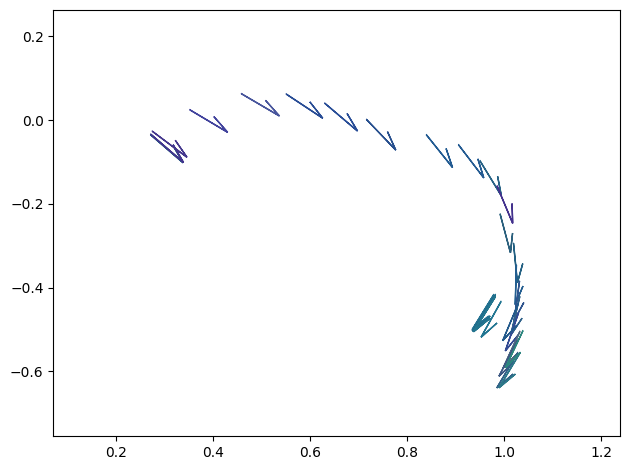

min : pca0   -15.864123
pca1   -12.113694
pca2   -11.487204
dtype: float64
max : pca0     0.248496
pca1    14.183777
pca2     7.743411
dtype: float64


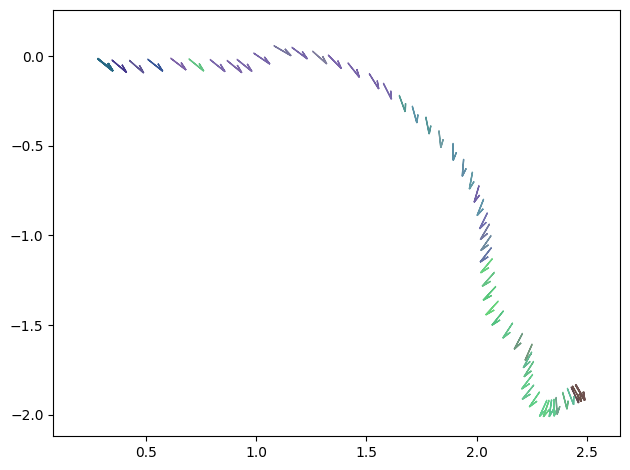

min : pca0   -5.186471
pca1   -9.729715
pca2    0.287236
dtype: float64
max : pca0     7.372935
pca1     8.705040
pca2    11.775522
dtype: float64


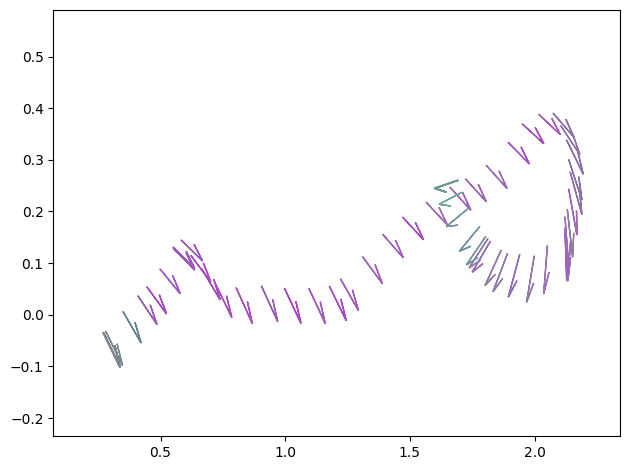

In [3]:
### from existing pca profile
# Load and select data & CLIP
rh, df, ids = load_dataset('RGBD_1', scale=None)
dfs = separate_session(df)
# for i, df in enumerate(dfs):
i = 0; df = dfs[0]
try:
    df = df.sort_values("timestamp")
    df = df.reset_index(drop=True)
    ids = get_ids(df)
    fn = 's'+str(i+1)
    clip = CLIP(model='ViT-B-32', fn=fn)
    df_s, df_f = clip.encode_rh(rh, df, ids)
    # PCA
    pca = PCA(profile='./result/pca_profile.pkl')
    df_p = pca.transform(df_f)
    df_p = pca_color(df_p)
    plot_viewpoint(df_p, 5, color=True)
    dfr = separate_room(df_f)
    for j, df_ in enumerate(dfr):
        # PCA
        pca = PCA(profile='./result/pca_profile.pkl')
        df_p = pca.transform(df_)
        df_p = pca_color(df_p)
        plot_viewpoint(df_p, 5, color=True)
except: pass